# Loan Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, f1_score, fbeta_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, make_scorer
)

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier


In [3]:
df = pd.read_csv('loan-10k.lrn.csv') 
df1= pd.read_csv('loan-10k.tes.csv')
df2= pd.read_csv('loan-10k.sol.ex.csv') 
df.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


## Read CSV Files

In [5]:
print(df.isna().sum())
df = df.dropna()
df1 = df1.dropna()

ID                          0
loan_amnt                   0
funded_amnt                 0
funded_amnt_inv             0
term                        0
                           ..
last_pymnt_d_month          0
last_pymnt_d_year           0
last_credit_pull_d_month    0
last_credit_pull_d_year     0
grade                       0
Length: 92, dtype: int64


grade
C    2989
B    2881
A    1821
D    1449
E     621
F     182
G      57
Name: count, dtype: int64


<Axes: xlabel='grade', ylabel='count'>

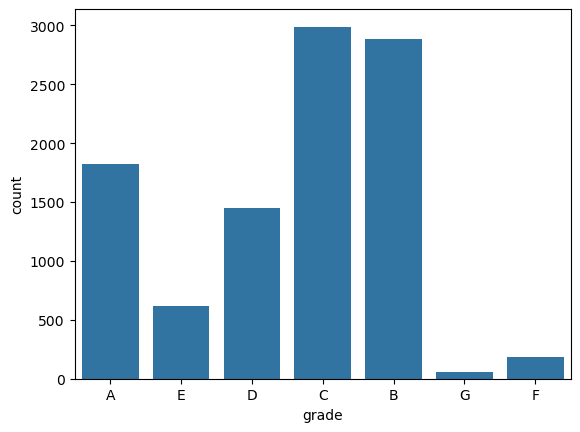

In [6]:
print(df['grade'].value_counts())
sns.countplot(x='grade', data=df)

In [7]:
df.columns

Index(['ID', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          10000 non-null  int64  
 1   loan_amnt                   10000 non-null  float64
 2   funded_amnt                 10000 non-null  float64
 3   funded_amnt_inv             10000 non-null  float64
 4   term                        10000 non-null  object 
 5   int_rate                    10000 non-null  float64
 6   installment                 10000 non-null  float64
 7   emp_length                  10000 non-null  object 
 8   home_ownership              10000 non-null  object 
 9   annual_inc                  10000 non-null  float64
 10  verification_status         10000 non-null  object 
 11  loan_status                 10000 non-null  object 
 12  pymnt_plan                  10000 non-null  object 
 13  purpose                     1000

In [9]:
df['last_credit_pull_d_month'].unique()


array([ 2, 11,  9,  3,  0,  7,  1,  4, 10,  6,  5,  8], dtype=int64)

In [10]:
df['fico_avg'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df['last_fico_avg'] = (df['last_fico_range_low'] + df['last_fico_range_high']) / 2

df1['fico_avg'] = (df1['fico_range_low'] + df1['fico_range_high']) / 2
df1['last_fico_avg'] = (df1['last_fico_range_low'] + df1['last_fico_range_high']) / 2


In [11]:
df.drop(columns=[
    'fico_range_low', 'fico_range_high',
    'last_fico_range_low', 'last_fico_range_high',
], inplace=True)
df1.drop(columns=[
    'fico_range_low', 'fico_range_high',
    'last_fico_range_low', 'last_fico_range_high',
], inplace=True)

## Checking for unique Values

In [13]:
unique_col=df.select_dtypes(include=['object'])
for col in unique_col:
    print(col, df[col].nunique(), "\n Unique values are ", df[col].unique(),"\n")

term 2 
 Unique values are  [' 36 months' ' 60 months'] 

emp_length 11 
 Unique values are  ['< 1 year' '1 year' '9 years' '10+ years' '3 years' '4 years' '7 years'
 '2 years' '5 years' '6 years' '8 years'] 

home_ownership 5 
 Unique values are  ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'OTHER'] 

verification_status 3 
 Unique values are  ['Not Verified' 'Source Verified' 'Verified'] 

loan_status 6 
 Unique values are  ['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'] 

pymnt_plan 2 
 Unique values are  ['n' 'y'] 

purpose 13 
 Unique values are  ['debt_consolidation' 'car' 'credit_card' 'other' 'major_purchase'
 'home_improvement' 'small_business' 'medical' 'vacation' 'moving' 'house'
 'renewable_energy' 'wedding'] 

addr_state 50 
 Unique values are  ['IL' 'OK' 'AZ' 'CA' 'FL' 'TX' 'PA' 'MA' 'NC' 'NV' 'SC' 'GA' 'NY' 'OR'
 'AL' 'VT' 'MD' 'KY' 'CO' 'IN' 'LA' 'MN' 'MI' 'WA' 'NJ' 'VA' 'WI' 'OH'
 'TN' 'CT' 'DC' 'HI' 'MO' 'DE' 'AR' 'KS' 'ME' 'MS' 'N

In [14]:
unique_col=df1.select_dtypes(include=['object'])
for col in unique_col:
    print(col, df1[col].nunique(), "\n Unique values are ", df1[col].unique(),"\n")

term 2 
 Unique values are  [' 36 months' ' 60 months'] 

emp_length 11 
 Unique values are  ['< 1 year' '10+ years' '6 years' '2 years' '3 years' '7 years' '4 years'
 '1 year' '8 years' '5 years' '9 years'] 

home_ownership 5 
 Unique values are  ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE'] 

verification_status 3 
 Unique values are  ['Not Verified' 'Source Verified' 'Verified'] 

loan_status 7 
 Unique values are  ['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default'] 

pymnt_plan 2 
 Unique values are  ['n' 'y'] 

purpose 13 
 Unique values are  ['home_improvement' 'debt_consolidation' 'other' 'medical'
 'major_purchase' 'house' 'credit_card' 'moving' 'vacation'
 'small_business' 'renewable_energy' 'car' 'wedding'] 

addr_state 50 
 Unique values are  ['TX' 'OK' 'FL' 'MA' 'CO' 'PA' 'VA' 'NC' 'NJ' 'NY' 'CA' 'MS' 'IL' 'MD'
 'DE' 'DC' 'NM' 'MI' 'AR' 'MO' 'WI' 'NV' 'WA' 'SC' 'IN' 'UT' 'CT' 'AZ'
 'NH' 'RI' 'AL' 'MN' 'LA' 'OR' 'KS' 'OH' 'KY

## Changing Encoding Cell

### Term

In [17]:

term_map = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(term_map)
df1['term'] = df1['term'].map(term_map)

print("df['term'] unique:", df['term'].unique())
print("df1['term'] unique:", df1['term'].unique())


df['term'] unique: [36 60]
df1['term'] unique: [36 60]


### Verification Status

In [19]:

verification_map = {
    'Not Verified': 0,
    'Source Verified': 1,
    'Verified': 2
}


df['verification_status'] = df['verification_status'].map(verification_map)
df1['verification_status'] = df1['verification_status'].map(verification_map)
print(df['verification_status'].unique())
print(df1['verification_status'].unique())



[0 1 2]
[0 1 2]


### Loan Status

In [21]:
df1 = df1[df1['loan_status'] != 'Default']
loan_status_map = {
    'Current': 0,
    'Fully Paid': 1,
    'Charged Off': 2,
    'Late (31-120 days)': 3,
    'In Grace Period': 4,
    'Late (16-30 days)': 5,
    'Default': 2  # Mapped to Charged Off
}

df['loan_status'] = df['loan_status'].map(loan_status_map)
df1['loan_status'] = df1['loan_status'].map(loan_status_map)

print(df['loan_status'].unique())
print(df1['loan_status'].unique())


[0 1 2 3 4 5]
[0 1 2 3 4 5]


### Home OwnerShip

In [23]:
from sklearn.preprocessing import LabelEncoder

# Combine unique values from both datasets
all_home_ownership = pd.concat([df['home_ownership'], df1['home_ownership']]).unique()

# Fit label encoder on combined values
le_home = LabelEncoder()
le_home.fit(all_home_ownership)


df['home_ownership'] = le_home.transform(df['home_ownership'])
df1['home_ownership'] = le_home.transform(df1['home_ownership'])


print(" Consistent Home Ownership Encoding:")
for code, label in enumerate(le_home.classes_):
    print(f"{code} ➝ {label}")


 Consistent Home Ownership Encoding:
0 ➝ ANY
1 ➝ MORTGAGE
2 ➝ NONE
3 ➝ OTHER
4 ➝ OWN
5 ➝ RENT


### Employment Length

In [25]:
combined_emp_length = pd.concat([df['emp_length'], df1['emp_length']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['emp_length'] = le_emp.transform(df['emp_length'])
df1['emp_length'] = le_emp.transform(df1['emp_length'])


print(" Consistent Encoding (code ➝ emp_length label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ emp_length label):
0 ➝ 1 year
1 ➝ 10+ years
2 ➝ 2 years
3 ➝ 3 years
4 ➝ 4 years
5 ➝ 5 years
6 ➝ 6 years
7 ➝ 7 years
8 ➝ 8 years
9 ➝ 9 years
10 ➝ < 1 year


In [26]:
df['emp_length']

0       10
1        0
2       10
3        9
4        0
        ..
9995     5
9996     1
9997    10
9998     0
9999     1
Name: emp_length, Length: 10000, dtype: int32

### Purpose

In [28]:

combined_emp_length = pd.concat([df['purpose'], df1['purpose']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['purpose'] = le_emp.transform(df['purpose'])
df1['purpose'] = le_emp.transform(df1['purpose'])


print(" Consistent Encoding (code ➝ purpose label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ purpose label):
0 ➝ car
1 ➝ credit_card
2 ➝ debt_consolidation
3 ➝ home_improvement
4 ➝ house
5 ➝ major_purchase
6 ➝ medical
7 ➝ moving
8 ➝ other
9 ➝ renewable_energy
10 ➝ small_business
11 ➝ vacation
12 ➝ wedding


### Payment Plan

In [30]:

combined_emp_length = pd.concat([df['pymnt_plan'], df1['pymnt_plan']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['pymnt_plan'] = le_emp.transform(df['pymnt_plan'])
df1['pymnt_plan'] = le_emp.transform(df1['pymnt_plan'])


print(" Consistent Encoding (code ➝ pymnt_plan label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ pymnt_plan label):
0 ➝ n
1 ➝ y


### Initial List Status

In [32]:

combined_emp_length = pd.concat([df['initial_list_status'], df1['initial_list_status']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['initial_list_status'] = le_emp.transform(df['initial_list_status'])
df1['initial_list_status'] = le_emp.transform(df1['initial_list_status'])


print(" Consistent Encoding (code ➝ initial_list_status label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ initial_list_status label):
0 ➝ f
1 ➝ w


### Application Type

In [34]:

combined_emp_length = pd.concat([df['application_type'], df1['application_type']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['application_type'] = le_emp.transform(df['application_type'])
df1['application_type'] = le_emp.transform(df1['application_type'])


print(" Consistent Encoding (code ➝ application_type label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ application_type label):
0 ➝ Individual
1 ➝ Joint App


### debt settlement flag

In [36]:

combined_emp_length = pd.concat([df['debt_settlement_flag'], df1['debt_settlement_flag']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['debt_settlement_flag'] = le_emp.transform(df['debt_settlement_flag'])
df1['debt_settlement_flag'] = le_emp.transform(df1['debt_settlement_flag'])


print(" Consistent Encoding (code ➝ debt_settlement_flag label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ debt_settlement_flag label):
0 ➝ N
1 ➝ Y


### Hardship Flag

In [38]:

combined_emp_length = pd.concat([df['hardship_flag'], df1['hardship_flag']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['hardship_flag'] = le_emp.transform(df['hardship_flag'])
df1['hardship_flag'] = le_emp.transform(df1['hardship_flag'])


print(" Consistent Encoding (code ➝ hardship_flag label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ hardship_flag label):
0 ➝ N
1 ➝ Y


### Disbursement Method

In [40]:

combined_emp_length = pd.concat([df['disbursement_method'], df1['disbursement_method']]).unique()
le_emp = LabelEncoder()
le_emp.fit(combined_emp_length)


df['disbursement_method'] = le_emp.transform(df['disbursement_method'])
df1['disbursement_method'] = le_emp.transform(df1['disbursement_method'])


print(" Consistent Encoding (code ➝ disbursement_method label):")
for code, label in enumerate(le_emp.classes_):
    print(f"{code} ➝ {label}")


 Consistent Encoding (code ➝ disbursement_method label):
0 ➝ Cash
1 ➝ DirectPay


In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])
print(le.classes_)                     # See original labels
print(df["grade"].unique())           # See encoded values


['A' 'B' 'C' 'D' 'E' 'F' 'G']
[0 4 3 2 1 6 5]


In [42]:
df2['grade'] = df2['grade'].map({'B': 4})
print(df2['grade'].unique())


[4]


In [43]:
df2

,ID,grade
0,3582,4
1,60498,4
2,53227,4
3,21333,4
4,3885,4
...,...,...
9995,89555,4
9996,88135,4
9997,51888,4
9998,51380,4


In [44]:
df['grade'].value_counts()

grade
2    2989
1    2881
0    1821
3    1449
4     621
5     182
6      57
Name: count, dtype: int64

In [45]:
df2['grade'].value_counts()

grade
4    10000
Name: count, dtype: int64

### Defineing target and features

In [47]:
X = df.drop(columns=['ID','grade', 'addr_state'])  # drop addr_state if it's high cardinality
y = df['grade']

## Training the model

## XGB Classifier

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=12433688)

In [51]:
param_grid_XGB = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200]
}

In [52]:

xgb_results = []

smote = SMOTE(random_state=12433688, sampling_strategy="minority")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

for max_depth, lr, n_est in itertools.product(param_grid_XGB['max_depth'],
                                              param_grid_XGB['learning_rate'],
                                              param_grid_XGB['n_estimators']):
    
    clf = XGBClassifier(
        eval_metric='mlogloss',
        max_depth=max_depth,
        learning_rate=lr,
        n_estimators=n_est,
        random_state=42
    )
    
    # Use a standard sklearn pipeline if needed; here it's not required, model is self-contained
    start = time.time()
    clf.fit(X_resampled, y_resampled)
    duration = time.time() - start

    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    xgb_results.append({
        'max_depth': max_depth,
        'learning_rate': lr,
        'n_estimators': n_est,
        'F1_macro': f1,
        'Accuracy': acc,
        'Runtime_sec': duration
    })


## Evaluating the model

In [54]:
results_df = pd.DataFrame(xgb_results)
results_df = results_df.sort_values(by='F1_macro', ascending=False)
display(results_df)


,max_depth,learning_rate,n_estimators,F1_macro,Accuracy,Runtime_sec
3,3,0.10,200,0.944813,0.9850,6.895459
15,7,0.10,200,0.943938,0.9885,11.469497
17,7,0.20,200,0.943569,0.9880,9.720081
11,5,0.20,200,0.943209,0.9875,9.056633
5,3,0.20,200,0.940886,0.9855,6.966006
9,5,0.10,200,0.940144,0.9865,9.743365
4,3,0.20,100,0.939973,0.9840,3.505818
8,5,0.10,100,0.933981,0.9865,4.959971
14,7,0.10,100,0.932030,0.9870,6.323033
13,7,0.05,200,0.931997,0.9870,12.481112


In [55]:
def evaluate_best_xgb_model(results_df, X_train, X_test, y_train, y_test, sampling_strategy='minority'):
    best_row = results_df.sort_values(by='F1_macro', ascending=False).iloc[0]
    print("Best XGBoost Config:")
    print(best_row)

    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    best_model = XGBClassifier(
        eval_metric='mlogloss',
        max_depth=int(best_row['max_depth']),
        learning_rate=float(best_row['learning_rate']),
        n_estimators=int(best_row['n_estimators']),
        random_state=12433688
    )

    best_model.fit(X_train_res, y_train_res)
    y_pred = best_model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return best_model


In [56]:
final_model=evaluate_best_xgb_model(results_df, X_train, X_test, y_train, y_test)


Best XGBoost Config:
max_depth          3.000000
learning_rate      0.100000
n_estimators     200.000000
F1_macro           0.944813
Accuracy           0.985000
Runtime_sec        6.895459
Name: 3, dtype: float64
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       364
           1       0.99      0.99      0.99       576
           2       0.99      0.99      0.99       598
           3       0.98      0.99      0.98       290
           4       0.97      0.94      0.96       124
           5       0.86      0.86      0.86        37
           6       0.77      0.91      0.83        11

    accuracy                           0.98      2000
   macro avg       0.94      0.95      0.94      2000
weighted avg       0.98      0.98      0.98      2000



In [57]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


Classification Report:
              precision    recall  f1-score   support

           0      0.986     0.995     0.990       364
           1      0.991     0.995     0.993       576
           2      0.997     0.995     0.996       598
           3      0.993     0.986     0.990       290
           4      0.992     0.952     0.971       124
           5      0.865     0.865     0.865        37
           6      0.714     0.909     0.800        11

    accuracy                          0.988      2000
   macro avg      0.934     0.957     0.944      2000
weighted avg      0.988     0.988     0.988      2000



In [58]:
cm = confusion_matrix(y_test, y_pred)
print(" Confusion Matrix:\n", cm)

 Confusion Matrix:
 [[362   2   0   0   0   0   0]
 [  3 573   0   0   0   0   0]
 [  0   3 595   0   0   0   0]
 [  2   0   2 286   0   0   0]
 [  0   0   0   2 118   4   0]
 [  0   0   0   0   1  32   4]
 [  0   0   0   0   0   1  10]]


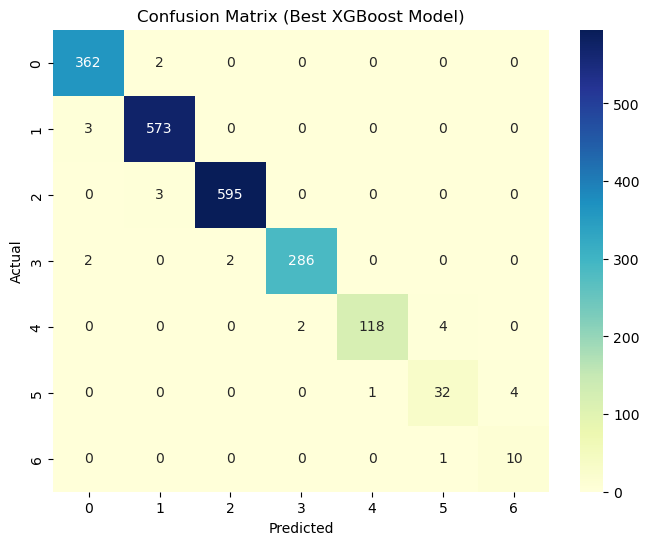

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix (Best XGBoost Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [60]:
# F2-score (macro)
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')

# F2-score (micro)
f2_micro = fbeta_score(y_test, y_pred, beta=2, average='micro')

print("F2 Macro:", f2_macro)
print("F2 Micro:", f2_micro)


F2 Macro: 0.9508769799789627
F2 Micro: 0.988


In [61]:

y_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)

# Metrics
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train F1 Score : {train_f1:.4f}")
print(f"Test F1 Score  : {test_f1:.4f}")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")


Train F1 Score : 0.9973
Test F1 Score  : 0.9446
Train Accuracy : 0.9972
Test Accuracy  : 0.9845


## Logistic Regression

## Training the model

In [64]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, stratify=y, test_size=0.2, random_state=12433688)

In [65]:
log_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(max_iter=1000, random_state=12433688, class_weight='balanced'))
])

sm = SMOTE(random_state=124336888, sampling_strategy='minority')
X_train_log, y_train_log = sm.fit_resample(X_train_log, y_train_log)
params_lr = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100, 500, 1000],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

# GridSearchCV
grid_lr = GridSearchCV(
    log_pipeline,
    param_grid=params_lr,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit and time it
start = time.time()
grid_lr.fit(X_train_log, y_train_log)
duration = time.time() - start

# Predict
y_pred_log = grid_lr.predict(X_test_log)

logreg_results = []

for i in range(len(grid_lr.cv_results_['params'])):
    logreg_results.append({
        'penalty': grid_lr.cv_results_['params'][i]['logisticregression__penalty'],
        'C': grid_lr.cv_results_['params'][i]['logisticregression__C'],
        'solver': grid_lr.cv_results_['params'][i]['logisticregression__solver'],
        'Mean_F1_weighted': grid_lr.cv_results_['mean_test_score'][i],
        'Std_F1_weighted': grid_lr.cv_results_['std_test_score'][i],
        'Runtime_sec': duration 
    })





Fitting 3 folds for each of 28 candidates, totalling 84 fits


## Evaluating the model

In [67]:
logreg_results_df = pd.DataFrame(logreg_results)
display(logreg_results_df.sort_values(by='Mean_F1_weighted', ascending=False))

,penalty,C,solver,Mean_F1_weighted,Std_F1_weighted,Runtime_sec
20,l2,500.00,newton-cg,0.895760,0.003734,362.32321
17,l2,100.00,lbfgs,0.895684,0.004216,362.32321
24,l2,1000.00,newton-cg,0.895153,0.003722,362.32321
16,l2,100.00,newton-cg,0.894995,0.003334,362.32321
25,l2,1000.00,lbfgs,0.894246,0.004250,362.32321
13,l2,10.00,lbfgs,0.894183,0.005221,362.32321
12,l2,10.00,newton-cg,0.894135,0.004836,362.32321
21,l2,500.00,lbfgs,0.893782,0.003481,362.32321
18,l2,100.00,sag,0.881016,0.004325,362.32321
26,l2,1000.00,sag,0.880925,0.004254,362.32321


In [68]:
def evaluate_best_logreg_model(logreg_results_df, X_train_log, X_test_log, y_train_log, y_test_log, sampling_strategy='minority'):
    # Get the best row (highest Mean_F1_weighted)
    best_row = logreg_results_df.sort_values(by='Mean_F1_weighted', ascending=False).iloc[0]
    print("Best Logistic Regression Config:")
    print(best_row)

    # Recreate model with best params
    best_model = LogisticRegression(
        penalty=best_row['penalty'],
        C=best_row['C'],
        solver=best_row['solver'],
        max_iter=1000,
        random_state=12433688,
        class_weight='balanced'
    )

    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_log, y_train_log = sm.fit_resample(X_train_log, y_train_log)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', best_model)
    ])

    # Fit & predict
    pipeline.fit(X_train_log, y_train_log)
    y_pred_log = pipeline.predict(X_test_log)
    y_train_pred_log = pipeline.predict(X_train_log)
    return best_model


In [69]:
print("Best Parameters:", grid_lr.best_params_)
print("Best CV Accuracy:", grid_lr.best_score_)

Best Parameters: {'logisticregression__C': 500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
Best CV Accuracy: 0.8957597423054096


In [70]:
final_model_log=evaluate_best_logreg_model(logreg_results_df,X_train_log, X_test_log, y_train_log, y_test_log)

Best Logistic Regression Config:
penalty                    l2
C                       500.0
solver              newton-cg
Mean_F1_weighted      0.89576
Std_F1_weighted      0.003734
Runtime_sec         362.32321
Name: 20, dtype: object


In [71]:
# Evaluate on test set
y_pred_log = grid_lr.predict(X_test_log)
print("Test Accuracy (GridSearch):", accuracy_score(y_test_log, y_pred_log))
print("F1 Score:", f1_score(y_test_log, y_pred_log, average='weighted'))


Test Accuracy (GridSearch): 0.8845
F1 Score: 0.8845339246502241


In [72]:
print("Classification Report:\n", classification_report(y_test_log, y_pred_log))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       364
           1       0.92      0.89      0.91       576
           2       0.91      0.91      0.91       598
           3       0.85      0.79      0.82       290
           4       0.70      0.76      0.73       124
           5       0.61      0.81      0.70        37
           6       0.57      0.36      0.44        11

    accuracy                           0.88      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.89      0.88      0.88      2000



In [73]:
print("Confusion Matrix:\n", confusion_matrix(y_test_log, y_pred_log))

Confusion Matrix:
 [[354  10   0   0   0   0   0]
 [ 27 515  34   0   0   0   0]
 [  0  32 543  22   1   0   0]
 [  2   0  22 229  36   1   0]
 [  0   0   0  19  94  11   0]
 [  0   0   0   0   4  30   3]
 [  0   0   0   0   0   7   4]]


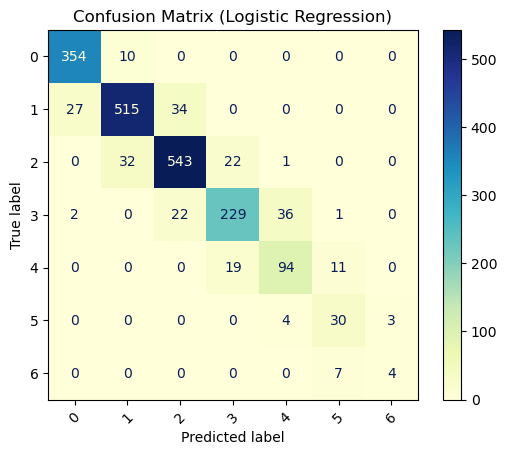

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test_log,
    y_pred_log,
    cmap='YlGnBu',
    xticks_rotation=45
)
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


In [75]:
print(" Logistic Regression Evaluation")
train_f1 = f1_score(y_train_log, y_train_log, average='weighted')
test_f1 = f1_score(y_test_log, y_pred_log, average='weighted')
f2_macro = fbeta_score(y_test_log, y_pred_log, beta=2, average='macro')
f2_micro = fbeta_score(y_test_log, y_pred_log, beta=2, average='micro')
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Train F1 Score (weighted):", train_f1)
print("Test F1 Score (weighted):", test_f1)
print("F2 Score (macro):", f2_macro)
print("F2 Score (micro):", f2_micro)

 Logistic Regression Evaluation
Train Accuracy: 0.99725
Test Accuracy: 0.9845
Train F1 Score (weighted): 1.0
Test F1 Score (weighted): 0.8845339246502241
F2 Score (macro): 0.781337808481619
F2 Score (micro): 0.8845


## Decison Tree

In [77]:
# 1. Split the dataset (same as before)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=12433688
)

In [78]:
sm = SMOTE(sampling_strategy='minority', random_state=12433688)
X_train_dt, y_train_dt = sm.fit_resample(X_train_dt, y_train_dt)


dt_pipeline = Pipeline([
    ('decisiontreeclassifier', DecisionTreeClassifier(
        class_weight='balanced',
        random_state=12433688
    ))
])


f2_macro = make_scorer(fbeta_score, beta=2, average='macro')


params_dt = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None,2],
    'decisiontreeclassifier__min_samples_split': [2,5],
    'decisiontreeclassifier__min_samples_leaf': [1,5],
    'decisiontreeclassifier__max_features': [None,'sqrt','log2'],
    'decisiontreeclassifier__ccp_alpha': [0.0, 0.001]  # cost-complexity pruning
}


grid_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=params_dt,
    scoring=f2_macro,
    cv=5,
    return_train_score=True
)


start = time.time()
grid_dt.fit(X_train_dt, y_train_dt)
duration = time.time() - start

y_pred_final = grid_dt.predict(X_test_dt)
print("Final Test Accuracy:", accuracy_score(y_test_dt, y_pred_final))


dt_results = []
for i in range(len(grid_dt.cv_results_['params'])):
    row = grid_dt.cv_results_['params'][i]
    dt_results.append({
        'criterion': row['decisiontreeclassifier__criterion'],
        'max_depth': row['decisiontreeclassifier__max_depth'],
        'min_samples_split': row['decisiontreeclassifier__min_samples_split'],
        'min_samples_leaf': row['decisiontreeclassifier__min_samples_leaf'],
        'max_features': row['decisiontreeclassifier__max_features'],
        'ccp_alpha': row['decisiontreeclassifier__ccp_alpha'],
        'F2_macro': grid_dt.cv_results_['mean_test_score'][i],
        'Train_F2_macro': grid_dt.cv_results_['mean_train_score'][i],
        'Runtime_sec': duration
    })

dt_results_df = pd.DataFrame(dt_results)
dt_results_df = dt_results_df.sort_values(by='F2_macro', ascending=False)
display(dt_results_df.head())


Final Test Accuracy: 0.987


,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,ccp_alpha,F2_macro,Train_F2_macro,Runtime_sec
25,entropy,NaN,5,1,None,0.000,0.957791,0.998037,145.967668
73,entropy,NaN,5,1,None,0.001,0.957682,0.996056,145.967668
72,entropy,NaN,2,1,None,0.001,0.955875,0.997542,145.967668
24,entropy,NaN,2,1,None,0.000,0.955773,1.000000,145.967668
75,entropy,NaN,5,5,None,0.001,0.953978,0.984828,145.967668


C:\Users\yashl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


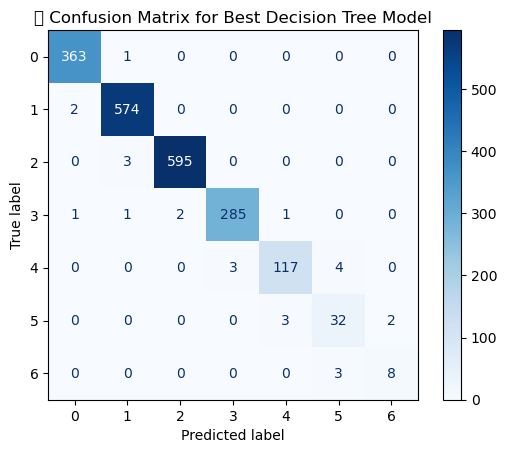

In [79]:
cm = confusion_matrix(y_test_dt, y_pred_final)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot(cmap='Blues')
plt.title("📊 Confusion Matrix for Best Decision Tree Model")
plt.show()


In [80]:
print(grid_dt.best_params_)

{'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 5}


In [81]:
dt_results_df = pd.DataFrame(dt_results)
dt_results_df = dt_results_df.sort_values(by='F2_macro', ascending=False)
display(dt_results_df)


,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,ccp_alpha,F2_macro,Train_F2_macro,Runtime_sec
25,entropy,NaN,5,1,None,0.000,0.957791,0.998037,145.967668
73,entropy,NaN,5,1,None,0.001,0.957682,0.996056,145.967668
72,entropy,NaN,2,1,None,0.001,0.955875,0.997542,145.967668
24,entropy,NaN,2,1,None,0.000,0.955773,1.000000,145.967668
75,entropy,NaN,5,5,None,0.001,0.953978,0.984828,145.967668
...,...,...,...,...,...,...,...,...,...
20,gini,2.0,2,1,log2,0.000,0.199632,0.201970,145.967668
21,gini,2.0,5,1,log2,0.000,0.199632,0.201970,145.967668
22,gini,2.0,2,5,log2,0.000,0.199632,0.201970,145.967668
23,gini,2.0,5,5,log2,0.000,0.199632,0.201970,145.967668


In [82]:
print(" Best Parameters:", grid_dt.best_params_)

 Best Parameters: {'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 5}


In [83]:
print(" Classification Report:\n", classification_report(y_test_dt, y_pred_final))
print(" Confusion Matrix:\n", confusion_matrix(y_test_dt, y_pred_final))

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       364
           1       0.99      1.00      0.99       576
           2       1.00      0.99      1.00       598
           3       0.99      0.98      0.99       290
           4       0.97      0.94      0.96       124
           5       0.82      0.86      0.84        37
           6       0.80      0.73      0.76        11

    accuracy                           0.99      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.99      0.99      0.99      2000

 Confusion Matrix:
 [[363   1   0   0   0   0   0]
 [  2 574   0   0   0   0   0]
 [  0   3 595   0   0   0   0]
 [  1   1   2 285   1   0   0]
 [  0   0   0   3 117   4   0]
 [  0   0   0   0   3  32   2]
 [  0   0   0   0   0   3   8]]


In [84]:
#  Collect evaluation metrics
model_summary = [
    {
        'Model': 'Logistic Regression',
        'Train Accuracy': accuracy_score(y_train_log, grid_lr.predict(X_train_log)),
        'Test Accuracy': accuracy_score(y_test_log, y_pred_log),
        'F1 Weighted': f1_score(y_test_log, y_pred_log, average='weighted'),
        'F2 Macro': fbeta_score(y_test_log, y_pred_log, beta=2, average='macro'),
        'F2 Micro': fbeta_score(y_test_log, y_pred_log, beta=2, average='micro')

    },
    {
        'Model': 'Decision Tree',
        'Train Accuracy': accuracy_score(y_train_dt, y_train_dt),
        'Test Accuracy': accuracy_score(y_test_dt, y_pred_final),
        'F1 Weighted': f1_score(y_test_dt, y_pred_final, average='weighted'),
        'F2 Macro': fbeta_score(y_test_dt, y_pred_final, beta=2, average='macro'),
        'F2 Micro': fbeta_score(y_test_dt, y_pred_final, beta=2, average='micro')
    },
    {
        'Model': 'XGBoost',
        'Train Accuracy': accuracy_score(y_train, final_model.predict(X_train)),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'F1 Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F2 Macro': fbeta_score(y_test, y_pred, beta=2, average='macro'),
        'F2 Micro': fbeta_score(y_test, y_pred, beta=2, average='micro')
    }
]

#  Display the final summary
summary_df = pd.DataFrame(model_summary)
display(summary_df)


,Model,Train Accuracy,Test Accuracy,F1 Weighted,F2 Macro,F2 Micro
0,Logistic Regression,0.923538,0.8845,0.884534,0.781338,0.8845
1,Decision Tree,1.000000,0.9870,0.986985,0.930796,0.9870
2,XGBoost,0.997250,0.9845,0.984551,0.949995,0.9845


## Random Forest

In [86]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


rf_basic = RandomForestClassifier(random_state=42)
rf_basic.fit(X_train_rf, y_train_rf)


y_pred_rf = rf_basic.predict(X_test_rf)

print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))


Accuracy: 0.8515
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       364
           1       0.93      0.91      0.92       576
           2       0.85      0.95      0.90       598
           3       0.66      0.81      0.73       290
           4       0.52      0.27      0.36       124
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        11

    accuracy                           0.85      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.83      0.85      0.84      2000



C:\Users\yashl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yashl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yashl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [88]:

smote = SMOTE(random_state=124336888, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rf, y_train_rf)

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestClassifier(random_state=12433688, class_weight='balanced'))
])

params_rf = {
    'randomforest__n_estimators': [50,100,500],
    'randomforest__max_depth': [ 10,  30],
    'randomforest__min_samples_split': [2,5, 10],
    'randomforest__min_samples_leaf': [1,2, 4]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=params_rf,
    cv=2,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)


start = time.time()
grid_rf.fit(X_train_resampled, y_train_resampled)
duration_rf = time.time() - start

y_pred_rf = grid_rf.predict(X_test_rf)


rf_results = []

for i in range(len(grid_rf.cv_results_['params'])):
    rf_results.append({
        'n_estimators': grid_rf.cv_results_['params'][i]['randomforest__n_estimators'],
        'max_depth': grid_rf.cv_results_['params'][i]['randomforest__max_depth'],
        'min_samples_split': grid_rf.cv_results_['params'][i]['randomforest__min_samples_split'],
        'min_samples_leaf': grid_rf.cv_results_['params'][i]['randomforest__min_samples_leaf'],
        'Mean_F1_weighted': grid_rf.cv_results_['mean_test_score'][i],
        'Std_F1_weighted': grid_rf.cv_results_['std_test_score'][i],
        'Runtime_sec': duration_rf
    })





Fitting 2 folds for each of 54 candidates, totalling 108 fits


In [89]:
print("Best Params:", grid_rf.best_params_)

Best Params: {'randomforest__max_depth': 10, 'randomforest__min_samples_leaf': 4, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 500}


In [90]:
rf_results_df = pd.DataFrame(rf_results)
display(rf_results_df.sort_values(by='Mean_F1_weighted', ascending=False))



,n_estimators,max_depth,min_samples_split,min_samples_leaf,Mean_F1_weighted,Std_F1_weighted,Runtime_sec
26,500,10,10,4,0.892515,0.011964,189.909386
17,500,10,10,2,0.892499,0.008373,189.909386
53,500,30,10,4,0.891301,0.009913,189.909386
44,500,30,10,2,0.890635,0.008512,189.909386
35,500,30,10,1,0.889999,0.007349,189.909386
8,500,10,10,1,0.889959,0.007727,189.909386
20,500,10,2,4,0.889959,0.010222,189.909386
23,500,10,5,4,0.889959,0.010222,189.909386
43,100,30,10,2,0.888192,0.006046,189.909386
14,500,10,5,2,0.887772,0.007769,189.909386


In [91]:
print("F1 Weighted on Test:", classification_report(y_test_rf, y_pred_rf))

F1 Weighted on Test:               precision    recall  f1-score   support

           0       0.94      0.98      0.96       364
           1       0.95      0.87      0.91       576
           2       0.88      0.91      0.90       598
           3       0.75      0.86      0.80       290
           4       0.65      0.62      0.63       124
           5       0.70      0.19      0.30        37
           6       0.40      0.36      0.38        11

    accuracy                           0.87      2000
   macro avg       0.75      0.69      0.70      2000
weighted avg       0.87      0.87      0.87      2000



In [92]:
def evaluate_best_rf_model(rf_results_df, X_train_rf, X_test_rf, y_train_rf, y_test_rf, sampling_strategy='minority'):

    best_row = rf_results_df.sort_values(by='Mean_F1_weighted', ascending=False).iloc[0]
    print("Best Random Forest Config:")
    print(best_row)

    
    best_rf_model = RandomForestClassifier(
    n_estimators = int(best_row['n_estimators']),
    max_depth = None if pd.isna(best_row['max_depth']) else int(best_row['max_depth']),
    min_samples_split = int(best_row['min_samples_split']),
    min_samples_leaf = int(best_row['min_samples_leaf']),
        class_weight='balanced',
        random_state=12433688
    )


    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_rf_res, y_train_rf_res = sm.fit_resample(X_train_rf, y_train_rf)


    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('randomforest', best_rf_model)
    ])


    pipeline.fit(X_train_rf, y_train_rf)
    y_pred_rf = pipeline.predict(X_test_rf)
    y_train_pred_rf = pipeline.predict(X_train_rf)


    print("\nClassification Report (Test):")
    print(classification_report(y_test_rf, y_pred_rf))

    print("Accuracy (Test):", accuracy_score(y_test_rf, y_pred_rf))

    return best_rf_model


In [93]:
final_model_rf=evaluate_best_rf_model(rf_results_df, X_train_rf, X_test_rf, y_train_rf, y_test_rf)


Best Random Forest Config:
n_estimators         500.000000
max_depth             10.000000
min_samples_split     10.000000
min_samples_leaf       4.000000
Mean_F1_weighted       0.892515
Std_F1_weighted        0.011964
Runtime_sec          189.909386
Name: 26, dtype: float64

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       364
           1       0.94      0.88      0.91       576
           2       0.89      0.91      0.90       598
           3       0.75      0.85      0.80       290
           4       0.62      0.60      0.61       124
           5       0.63      0.32      0.43        37
           6       0.00      0.00      0.00        11

    accuracy                           0.87      2000
   macro avg       0.68      0.65      0.66      2000
weighted avg       0.87      0.87      0.87      2000

Accuracy (Test): 0.871


In [94]:
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.942     0.981     0.961       364
           1      0.945     0.870     0.906       576
           2      0.881     0.913     0.897       598
           3      0.750     0.859     0.801       290
           4      0.647     0.621     0.634       124
           5      0.700     0.189     0.298        37
           6      0.400     0.364     0.381        11

    accuracy                          0.871      2000
   macro avg      0.752     0.685     0.697      2000
weighted avg      0.871     0.871     0.867      2000



In [95]:
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print(" Confusion Matrix:\n", cm)

 Confusion Matrix:
 [[363   1   0   0   0   0   0]
 [  2 574   0   0   0   0   0]
 [  0   3 595   0   0   0   0]
 [  1   1   2 285   1   0   0]
 [  0   0   0   3 117   4   0]
 [  0   0   0   0   3  32   2]
 [  0   0   0   0   0   3   8]]


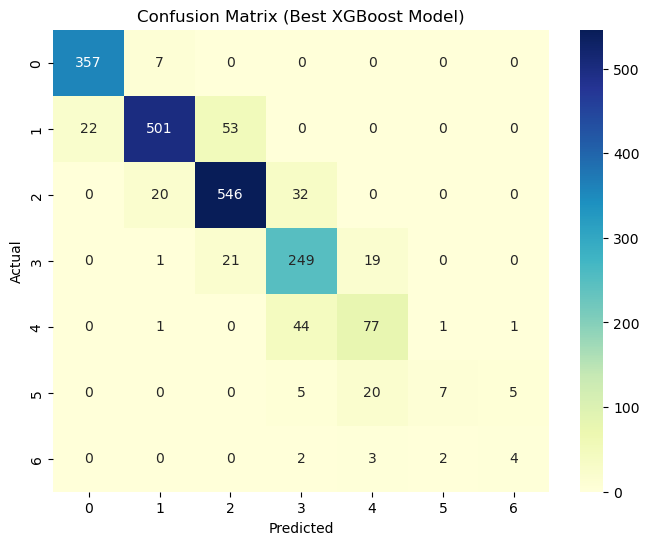

In [96]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix (Best XGBoost Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [104]:

model_summary = [
    {
        'Model': 'Logistic Regression',
        'Train Accuracy': accuracy_score(y_train_log, grid_lr.predict(X_train_log)),
        'Test Accuracy': accuracy_score(y_test_log, y_pred_log),
        'F1 Weighted': f1_score(y_test_log, y_pred_log, average='weighted'),
        'F2 Macro': fbeta_score(y_test_log, y_pred_log, beta=2, average='macro'),

    },
    {
        'Model': 'Decision Tree',
        'Train Accuracy': accuracy_score(y_train_dt, y_train_dt),
        'Test Accuracy': accuracy_score(y_test_dt, y_pred_final),
        'F1 Weighted': f1_score(y_test_dt, y_pred_final, average='weighted'),
        'F2 Macro': fbeta_score(y_test_dt, y_pred_final, beta=2, average='macro'),

    },
    {
        'Model': 'XGBoost',
        'Train Accuracy': accuracy_score(y_train, final_model.predict(X_train)),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'F1 Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F2 Macro': fbeta_score(y_test, y_pred, beta=2, average='macro'),

    },
        {
        'Model': 'Random Forest',
        'Train Accuracy': accuracy_score(y_train_rf, grid_rf.predict(X_train_rf)),
        'Test Accuracy': accuracy_score(y_test_rf, y_pred_rf),
        'F1 Weighted': f1_score(y_test_rf, y_pred_rf, average='weighted'),
        'F2 Macro': fbeta_score(y_test_rf, y_pred_rf, beta=2, average='macro'),
    }
    
]


summary_df = pd.DataFrame(model_summary)
display(summary_df)


,Model,Train Accuracy,Test Accuracy,F1 Weighted,F2 Macro
0,Logistic Regression,0.923538,0.8845,0.884534,0.781338
1,Decision Tree,1.000000,0.9870,0.986985,0.930796
2,XGBoost,0.997250,0.9845,0.984551,0.949995
3,Random Forest,0.962750,0.8705,0.866875,0.687913
